In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import warnings

import helpers as hlp
import helpers.features as feat
import helpers.dataset.PlantVillage as pv
import helpers.split as split
import helpers.visual_words as vw

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)
print()


#
# train/test
#
train, test = split.load(configs.split)

print("Train size:", len(train))
print("Test size:", len(test))
print()


#
# orb
#
orb_bovw = vw.load_bovw(configs.orb_bovw, None)
orb_pv_vw = vw.load_dataset_vw(configs.orb_dataset_vw,
                               None,
                               None,
                               None,
                               None)
    
print("ORB BoVW clusters:", orb_bovw.model.cluster_centers_.shape)
print("ORB PlantVillage Visual Words:", orb_pv_vw.vw_freqs.shape)
print()


#
# sift
#
sift_bovw = vw.load_bovw(configs.sift_bovw, None)
sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw,
                                None,
                                None,
                                None,
                                None)

print("Sift BoVW clusters:", sift_bovw.model.cluster_centers_.shape)
print("Sift PlantVillage Visual Words:", sift_pv_vw.vw_freqs.shape)

Dataset (60343, 5)

Train size: 3711
Test size: 928

ORB BoVW clusters: (500, 32)
ORB PlantVillage Visual Words: (4639, 500)

Sift BoVW clusters: (500, 128)
Sift PlantVillage Visual Words: (4639, 500)


In [4]:
#
# mettre le data dans une forme acceptable pour sklearn
#
train_y = pv_dataframe.loc[train, "label"]
test_y = pv_dataframe.loc[test, "label"]

# orb_pv_vw a ete construit en respectant l'ordre donne par train/test: alors faire gaffe
orb_train_x = orb_pv_vw.train_vw_freqs
orb_test_x = orb_pv_vw.test_vw_freqs

assert orb_train_x.shape[0] == train_y.shape[0]
assert orb_test_x.shape[0] == test_y.shape[0]

print("ORB PlantVillage train Visual Words", orb_train_x.shape)
print("ORB PlantVillage test Visual Words", orb_train_x.shape)

ORB PlantVillage train Visual Words (3711, 500)
ORB PlantVillage test Visual Words (3711, 500)


In [10]:
#
# KNN
#

knn_model_filename = "models/knn_orb.pkl"

with warnings.catch_warnings():    
    warnings.simplefilter(action='ignore', category=FutureWarning)

    if os.path.exists(knn_model_filename):
        # charger le modele pre-entrainer
        with open(knn_model_filename, "rb") as file:
            knn_pipe = pickle.load(file)

        test_y_hat = knn_pipe.predict(orb_test_x)
        
        print("KNN n_neighbors:", knn_pipe.named_steps["knn"].n_neighbors)
        print("KNN test score:", accuracy_score(test_y, test_y_hat).round(4))
    else:
        CROSS_VALIDATION_FOLDS = 5

        knn_pipe = Pipeline([("scaler", StandardScaler()),
                             ("knn", KNeighborsClassifier())])

        knn_pipe_parameters = {"knn__n_neighbors": range(1, 5)}

        knn_search = GridSearchCV(knn_pipe, 
                                  knn_pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS)

        with hlp.Profile() as knn_search_time:
            knn_search.fit(orb_train_x, train_y)

        knn_pipe = knn_search.best_estimator_
        test_y_hat = knn_pipe.predict(orb_test_x)

        print("KNN best params", knn_search.best_params_)
        print("KNN search time:", knn_search_time.round_duration(), "s")
        print("KNN train score:", knn_search.best_score_.round(4))
        print("KNN n_neighbors:", knn_pipe.named_steps["knn"].n_neighbors)
        print("KNN test score:", accuracy_score(test_y, test_y_hat).round(4))

        # sauvegarde du meilleur modele knn
        head, _ = os.path.split(knn_model_filename)
        os.makedirs(head, exist_ok=True)
        with open(knn_model_filename, "wb") as file:
            pickle.dump(knn_pipe, file)

KNN n_neighbors: 2
KNN test score: 0.3147


Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


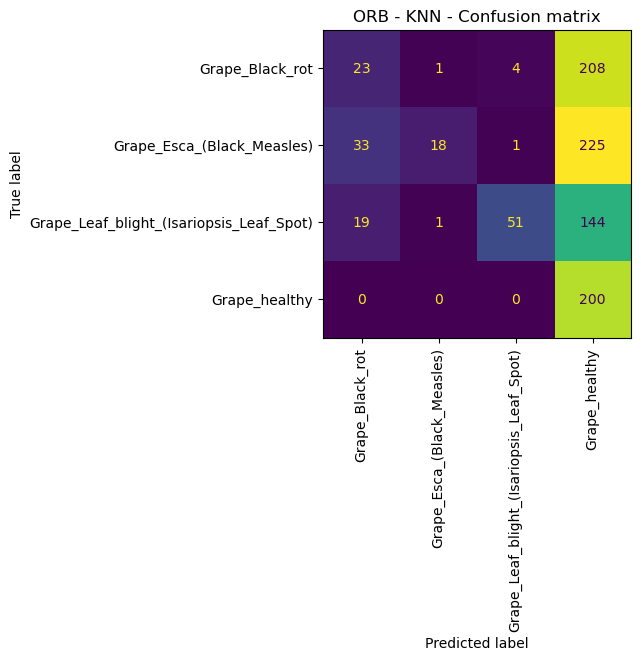

In [11]:
print( test_y.value_counts() )

plt.figure(figsize=(5, 4))

cm = confusion_matrix(test_y, test_y_hat)
cmd = ConfusionMatrixDisplay(cm, 
                            display_labels=knn_pipe.classes_)
cmd.plot(ax=plt.gca())
cmd.im_.colorbar.remove()

plt.title("ORB - KNN - Confusion matrix")
plt.xticks(rotation=90)
plt.show()